**Multi-period decision making applied to cryptocurrency investment scenario**
*(in review)*

*R.Torres, M.A.Solis, R.Salas, A.F.Bariviera*

*Execution of i-th cell requires execution of previous one, except for cells labeled as "(optional, not in article)"*

**move dataset files into folder "datasets" (create it in the same location as this python notebook)**

**Parameters**

In [1]:
n_all = 68 # total number of cryptos considered with data available
time_horizon = 88 # number of days for generating figure data
time_horizon_tables = 5 # number of days for showing tables
attr_labels = ["benefit", "benefit", "benefit"]
n_attributes = len(attr_labels) # day-profitability, day-variability and (log of) market capitalization
linguistic_var_number = 5

**Useful functions** - Appropriate functions to be applied on the case of study

In [2]:
%matplotlib inline
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import sys
import random
from math import exp,log

def normalization(attr_values, attr_labels, T = time_horizon):
    normal = {}
    factors = {}
    for t in range(T):
        factors[t] = []
        for a in range(len(attr_labels)):
            attributes = []
            for abbreviation in attr_values.keys():
                attributes.append(attr_values[abbreviation][t][a])
            if attr_labels[a] == "benefit":
                factors[t].append(max(attributes))
            else:
                factors[t].append(min(attributes))
    for abbreviation in attr_values.keys():
        normal[abbreviation] = {}
        for t in range(T):
            normal[abbreviation][t] = []
            for a in range(len(attr_labels)):
                if attr_labels[a] == "benefit":
                    normal[abbreviation][t].append(round(attr_values[abbreviation][t][a]/factors[t][a],2))
                else:
                    normal[abbreviation][t].append(round(factors[t][a]/(attr_values[abbreviation][t][a]+1e-9),2))
    return normal

def linguistic_values(values,n_vl):
    n_att = len(values.keys())
    delta = int(100/(n_vl -1))
    p = range(0,101,delta)
    prc = []
    for i in range(n_att):
        aux = list(values[i])
        aux.sort()
        prc.append(list(np.percentile(aux,p)))
    LV = []
    for i in range(n_att):
        LV.append([])
        LV[-1].append([prc[i][0],prc[i][0],prc[i][1]])
        for j in range(linguistic_var_number-2):
            LV[-1].append(prc[i][j:j+3])
        LV[-1].append([prc[i][linguistic_var_number-2],prc[i][linguistic_var_number-1],prc[i][linguistic_var_number-1]])    
    return LV

def triangle (z, a, b, c):
    y = np.zeros(z.shape)
    y[z <= a] = 0
    y[z >= c] = 0
    first_half = np.logical_and(a < z, z <= b)
    y[first_half] = (z[first_half]-a) / (b-a)
    second_half = np.logical_and(b < z, z < c)
    y[second_half] = (c-z[second_half]) / (c-b)
    return y

def weighting_years(alpha, horizon_time): # BUM function
    weights = []
    for t in range(horizon_time):
        weights.append(round((exp(alpha*t/horizon_time)-exp(alpha*(t-1)/horizon_time))/(exp(alpha)-1),2))
    return weights

def membership_atleast(x,p,A):
    mu = 0
    p = p - 1
    if x < A[p][0]:
        mu = 0
    elif x >= A[p][1]:
        mu = 1
    else:
        mu = float((A[p][0] - x)) / (A[p][0] - A[p][1])
    return round(mu,2)

def membership_atmost(x,p,A):
    mu = 0
    p = p - 1
    if x <= A[p][1]:
        mu = 1
    elif x > A[p][2]:
        mu = 0
    else:
        mu = float((x - A[p][2])) / (A[p][1] - A[p][2])
    return round(mu,2)

**Formatting and exporting new-formatted data** (Original dataset comes from coinmarketcap.com)

User should have writing permission for exporting new data

In [3]:
cryptos = {}
all_resources = {}
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
years = range(2018,2019) # according to datasets

for i in range(1,n_all+1): # reads all cryptocurrencies data in order to compute percentiles later
    file = open("datasets/"+str(i)+".csv")
    info = file.readline()
    abbreviation,name = info.strip().strip(";").split(";")
    for cnt,line in enumerate(file):
        if cnt == 0:
            cryptos[abbreviation] = name # relates a given cryptocurrency with its abbreviation
            all_resources[abbreviation] = {} # collects data for all available cryptocurrencies
        elif cnt > 1:
            data = line.strip().split(";")
            if len(data[0]) > 0:
                month = months[int(data[0].split("-")[1])-1]
                time = "/".join([data[0].split("-")[-1],month])
                for j in range(len(data[1:])):
                    data[j+1] = data[j+1].replace(".","").replace(",",".").replace("-","0")
                open_price,close_price,capitalization = float(data[1]),float(data[4]),int(data[-1])
                high,low = float(data[2]),float(data[3])
                if time not in all_resources[abbreviation]:
                    all_resources[abbreviation][time] = [] # collects attribute values by month/year
                all_resources[abbreviation][time].insert(0,(close_price/open_price,high/low,log(float(capitalization)+sys.float_info.min)))
    file.close()
    file = open("datasets/"+"".join(["new",str(i)])+".csv","w")
    file.write(abbreviation + "\n")
    file.write("day-profitability;day-variability;(log of) market capitalization\n")
    for y in years:
        for m in months:
            key = "/".join([str(y),m])
            if key in all_resources[abbreviation]:
                for attributes in all_resources[abbreviation][key]:
                    file.write(";".join(map(str,attributes)) + "\n")
    file.close()

**Table 1**: Values of the attributes of the cryptocurrencies that are of our interest.

In [4]:
resources = 5
attr_values = {}
all_resources = {}
for i in range(1,n_all+1):
    file = open("datasets/new"+str(i)+".csv")
    info = file.readline()
    abbreviation = info.strip()
    if i <= resources:
        attr_values[abbreviation] = {}
    all_resources[abbreviation] = {}
    for cnt,line in enumerate(file):
        if cnt > 1:
            data = line.strip().split(";")
            profit,variab,capit = round(float(data[0]),2),round(float(data[1]),2),round(float(data[2]),2)
            if capit < 0:
                capit = 0
            if i <= resources:
                attr_values[abbreviation][cnt-2] = (profit,variab,capit)
            all_resources[abbreviation][cnt-2] = (profit,variab,capit)
    file.close()
msg = "{:>5}"
for i,abbreviation in enumerate(attr_values.keys()):
    print("\n\nA" + str(i+1) + ":",abbreviation)
    for a in range(1,n_attributes+1):
        print("\nG" + str(a) + ":", end='\t')
        for t in range(time_horizon_tables):
            print(msg.format(attr_values[abbreviation][t][a-1]),end='\t')



A1: BTC

G1:	 1.01	 1.03	  1.0	  1.0	 0.94	
G2:	 1.03	 1.05	 1.03	 1.02	 1.08	
G3:	25.96	25.99	25.99	 26.0	25.93	

A2: ETH

G1:	 0.98	  1.0	 1.01	 0.98	 0.96	
G2:	 1.03	 1.02	 1.03	 1.02	 1.05	
G3:	25.15	25.15	25.17	25.15	25.11	

A3: XRP

G1:	 0.98	  1.0	 1.11	 0.95	 0.97	
G2:	 1.04	 1.03	 1.15	 1.13	 1.08	
G3:	 24.3	24.29	24.39	24.35	24.31	

A4: LTC

G1:	 1.01	 0.99	 1.02	 0.99	 0.93	
G2:	 1.04	 1.04	 1.04	 1.03	 1.09	
G3:	23.19	23.18	 23.2	23.18	23.11	

A5: BCH

G1:	 0.99	  1.0	 1.02	 0.99	 0.95	
G2:	 1.04	 1.04	 1.05	 1.02	 1.07	
G3:	 23.8	 23.8	23.81	23.79	23.74	

**Table 2**: Normalized attributes values of the cryptocurrencies that are of our interest.

In [5]:
normal = normalization(attr_values,attr_labels)
msg = "{:>5}"
for i,abbreviation in enumerate(normal.keys()):
    print("\n\nA" + str(i+1) + ":",abbreviation)
    for a in range(1,n_attributes+1):
        print("\nG" + str(a) + ":", end='\t')
        for t in range(time_horizon_tables):
            print(msg.format(normal[abbreviation][t][a-1]),end='\t')



A1: BTC

G1:	  1.0	  1.0	  0.9	  1.0	 0.97	
G2:	 0.99	  1.0	  0.9	  0.9	 0.99	
G3:	  1.0	  1.0	  1.0	  1.0	  1.0	

A2: ETH

G1:	 0.97	 0.97	 0.91	 0.98	 0.99	
G2:	 0.99	 0.97	  0.9	  0.9	 0.96	
G3:	 0.97	 0.97	 0.97	 0.97	 0.97	

A3: XRP

G1:	 0.97	 0.97	  1.0	 0.95	  1.0	
G2:	  1.0	 0.98	  1.0	  1.0	 0.99	
G3:	 0.94	 0.93	 0.94	 0.94	 0.94	

A4: LTC

G1:	  1.0	 0.96	 0.92	 0.99	 0.96	
G2:	  1.0	 0.99	  0.9	 0.91	  1.0	
G3:	 0.89	 0.89	 0.89	 0.89	 0.89	

A5: BCH

G1:	 0.98	 0.97	 0.92	 0.99	 0.98	
G2:	  1.0	 0.99	 0.91	  0.9	 0.98	
G3:	 0.92	 0.92	 0.92	 0.91	 0.92	

**Table 3**: Linguistic Decision Matrix

In [6]:
LV = {}
aux = {}
all_normalized = normalization(all_resources,attr_labels)
for t in range(time_horizon):
    aux[t] = {}
    for a in range(len(attr_labels)):
        aux[t][a] = []
        for abbreviation in all_normalized.keys():
            aux[t][a].append(all_normalized[abbreviation][t][a])
    LV[t] = linguistic_values(aux[t],linguistic_var_number)
linguistic = {}
for abbreviation in normal.keys():
    linguistic[abbreviation] = {}
    for t in range(time_horizon):
        linguistic[abbreviation][t] = []
        for a in range(n_attributes):
            mu = []
            for level in range(linguistic_var_number):
                if attr_labels[a] == "benefit":
                    mu.append(membership_atleast(normal[abbreviation][t][a],level,LV[t][a]))
                else:
                    mu.append(membership_atmost(normal[abbreviation][t][a],level,LV[t][a]))
            if attr_labels[a] == "benefit":
                linguistic[abbreviation][t].append(len(mu)-1-mu[::-1].index(max(mu))-2)
            else:
                linguistic[abbreviation][t].append(mu.index(max(mu))-2)
msg = "{:>5}"
for i,abbreviation in enumerate(linguistic.keys()):
    print("\n\nA" + str(i+1) + ":",abbreviation)
    for a in range(1,n_attributes+1):
        print("\nG" + str(a) + ":", end='\t')
        for t in range(time_horizon_tables):
            print(msg.format(linguistic[abbreviation][t][a-1]),end='\t')



A1: BTC

G1:	    2	    2	    0	    2	    2	
G2:	    2	    2	    2	    2	    2	
G3:	    2	    2	    2	    2	    2	

A2: ETH

G1:	    2	    2	    1	    2	    2	
G2:	    2	    2	    2	    2	    2	
G3:	    2	    2	    2	    2	    2	

A3: XRP

G1:	    2	    2	    2	    2	    2	
G2:	    2	    2	    2	    2	    2	
G3:	    2	    2	    2	    2	    2	

A4: LTC

G1:	    2	    2	    2	    2	    2	
G2:	    2	    2	    2	    2	    2	
G3:	    2	    2	    2	    2	    2	

A5: BCH

G1:	    2	    2	    2	    2	    2	
G2:	    2	    2	    2	    2	    2	
G3:	    2	    2	    2	    2	    2	

(optional, not in article) **Triangles** - Membership function for each attribute on the first five days

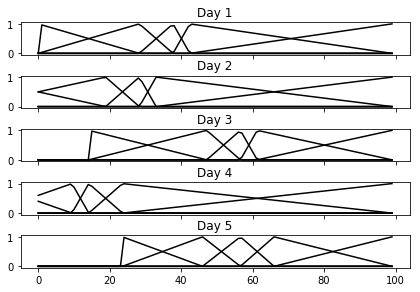

In [7]:
attribute = 0 # analyzing first attribute (day-profitability)
y = [0,1,0]
f, ax = plt.subplots(time_horizon_tables, sharex = True)
f.tight_layout()
axes = plt.gca()
for i in range(linguistic_var_number):
    for t in range(time_horizon_tables):
        a,b,c = LV[t][attribute][i]
        z = np.linspace(LV[0][attribute][0][0], LV[time_horizon_tables-1][attribute][-1][-1], num = 100)
        y = triangle(z,a,b,c)
        ax[t].set_title('Day '+str(t+1), color='k')
        ax[t].plot(y,color='k')
plt.show()
#uncomment next line for exporting figure
#f.savefig('a'+str(attribute+1)+'mf'+str(time_horizon)+'days.eps')

**Table 4**: Attribute aggregation using the LWA operator.

In [8]:
attr_aggr = {}
attr_weights = np.ones(n_attributes)*(1.0/n_attributes)
for abbreviation in linguistic.keys():
    attr_aggr[abbreviation] = {}
    for t in range(time_horizon):
        attr_aggr[abbreviation][t] = round(np.dot(linguistic[abbreviation][t],np.transpose(attr_weights)),2)
msg = "{:>5}"
for i,abbreviation in enumerate(attr_aggr.keys()):
    print("\nA" + str(i+1) + ":",abbreviation,end="\t")
    for t in range(time_horizon_tables):
        print(msg.format(attr_aggr[abbreviation][t]),end='\t')    
    print("\n")


A1: BTC	  2.0	  2.0	 1.33	  2.0	  2.0	


A2: ETH	  2.0	  2.0	 1.67	  2.0	  2.0	


A3: XRP	  2.0	  2.0	  2.0	  2.0	  2.0	


A4: LTC	  2.0	  2.0	  2.0	  2.0	  2.0	


A5: BCH	  2.0	  2.0	  2.0	  2.0	  2.0	



**Table 5**: Temporal aggregation for each cryptocurrency.

In [9]:
z = {}
for t in range(time_horizon):
    z[t] = {}
    weights = weighting_years(0.5,t+1)
    for abbreviation in attr_aggr.keys():
        aux = []
        for tau in range(t+1):
            aux.append(attr_aggr[abbreviation][tau])
        z[t][abbreviation] = round(np.dot(aux,np.transpose(weights)),2)
msg = "{:>5}"
for t in range(time_horizon_tables):
    print("\nt" + str(t) + ":",end="\t")
    for abbreviation in z[t].keys():
        print(msg.format(z[t][abbreviation]),end='\t')    


t0:	 1.22	 1.22	 1.22	 1.22	 1.22	
t1:	 1.56	 1.56	 1.56	 1.56	 1.56	
t2:	 1.48	 1.59	  1.7	  1.7	  1.7	
t3:	 1.61	 1.68	 1.76	 1.76	 1.76	
t4:	  1.7	 1.76	 1.82	 1.82	 1.82	

**Table 6**: Ranking of best alternatives using DLWA operator.

In [10]:
msg = "{:>5}"
for t in range(time_horizon_tables):
    print("\nDay" + str(t+1) + ":",end="\t")
    ordered = sorted(list(z[t].items()),key=lambda x: x[1],reverse=True)
    for abbreviation,value in ordered:
        print(msg.format(abbreviation),end='\t')


Day1:	  BTC	  ETH	  XRP	  LTC	  BCH	
Day2:	  BTC	  ETH	  XRP	  LTC	  BCH	
Day3:	  XRP	  LTC	  BCH	  ETH	  BTC	
Day4:	  XRP	  LTC	  BCH	  ETH	  BTC	
Day5:	  XRP	  LTC	  BCH	  ETH	  BTC	

**Table 7**: Ranking of the best alternative for the first five days of data.

In [11]:
choices = {}
random.seed(100)
print("Day\tDLWA\tRandom")
for t in range(time_horizon_tables):
    print(str(t+1)+":",end="\t")
    ordered = sorted(list(z[t].items()),key=lambda x: x[1],reverse=True)
    any_crypto = random.choice(list(attr_values.keys()))
    print(ordered[0][0],end="\t")
    print(any_crypto)

Day	DLWA	Random
1:	BTC	ETH
2:	BTC	LTC
3:	XRP	LTC
4:	XRP	ETH
5:	XRP	LTC


**Table 8**: Dollars obtained when buying at opening price and selling at closing value.

In [12]:
initial_investment = 100
prices = {}
for i in range(1,resources+1): # reads cryptocurrencies values in order to compute profits or losses
    total_days = sum(1 for line in open("datasets/"+str(i)+".csv"))
    file = open("datasets/"+str(i)+".csv")
    lines = file.readlines()
    file.close()
    file = open("datasets/"+str(i)+".csv")
    info = file.readline()
    abbreviation,name = info.strip().strip(";").split(";")
    for cnt,line in enumerate(file):
        t = total_days-cnt-2
        if cnt == 0:
            prices[abbreviation] = {}
        elif cnt > 1:
            data = line.strip().split(";")
            if len(data[0]) > 0:
                for j in range(len(data[1:])):
                    data[j+1] = data[j+1].replace(".","").replace(",",".").replace("-","0")
                open_price,close_price,capitalization = float(data[1]),float(data[4]),int(data[-1])
            if t <= time_horizon:
                prices[abbreviation][t] = (open_price,close_price)
    file.close()
investment = [initial_investment]
investment_btc = [initial_investment]
random_investment = [initial_investment]
random.seed(100)
print("Day\tBTC\tDLWA\tRandom")
for t in range(time_horizon_tables):
    choices = sorted(list(z[t].items()),key=lambda x: x[1],reverse=True)
    btc = investment_btc[t]/prices['BTC'][t][0]
    investment_btc.append(int(round(btc*prices['BTC'][t][1])))
    crypto_amount = investment[t]/prices[choices[0][0]][t][0]
    investment.append(int(round(crypto_amount*prices[choices[0][0]][t][1])))
    any_crypto = random.choice(list(attr_values.keys()))
    random_amount = random_investment[t]/prices[any_crypto][t][0]
    random_investment.append(int(round(random_amount*prices[any_crypto][t][1])))
    print(t,end=":\t")
    print(investment_btc[-1],end="\t")
    print(investment[-1],end="\t")
    print(random_investment[-1])

Day	BTC	DLWA	Random
0:	105	105	102
1:	106	106	103
2:	110	106	101
3:	110	118	102
4:	110	112	101


**Table 9**: 2 cryptocurrencies portfolio comparison, except for complete portfolio which considers all five resources.

In [13]:
desired_portfolio = 2
initial_investment = 100
portfolio_choices = {}
for t in z.keys():
    ordered = sorted(list(z[t].items()),key=lambda x: x[1],reverse=True)
    portfolio_choices[t] = []
    for i in range(desired_portfolio):
        portfolio_choices[t].append(ordered[i][0])
    
dlwa = {}
whole = {}
random_portfolio = {}
dlwa_values = [initial_investment]
whole_values = [initial_investment]
random_values = [initial_investment]
for i in range(desired_portfolio):
    dlwa[i] = [initial_investment/desired_portfolio]
    random_portfolio[i] = [initial_investment/desired_portfolio]
for i in range(resources):
    whole[i] = [initial_investment/resources]
random.seed(100)

cryptos = list(attr_values.keys())
print("Day\tComplete DLWA\tRandom")
for t in range(time_horizon_tables):
    day_value = 0
    day_whole_value = 0
    day_random = 0
    for i in range(resources):
        buying_from_whole = whole[i][-1]/prices[cryptos[i]][t][0]
        whole[i].append(int(round(buying_from_whole*prices[cryptos[i]][t][1])))
        day_whole_value += whole[i][-1]
    whole_values.append(day_whole_value)
    for i in range(desired_portfolio):
        any_crypto = random.choice(cryptos)
        buying_random = random_portfolio[i][-1]/prices[any_crypto][t][0]
        random_portfolio[i].append(int(round(buying_random*prices[any_crypto][t][1])))
        day_random += random_portfolio[i][-1]
        buying_dlwa = dlwa[i][-1]/prices[portfolio_choices[t][i]][t][0]
        dlwa[i].append(int(round(buying_dlwa*prices[portfolio_choices[t][i]][t][1])))
        day_value += dlwa[i][-1]
    dlwa_values.append(day_value)
    random_values.append(day_random)
    print(t,end=":\t")
    print(whole_values[-1],end="\t")
    print(dlwa_values[-1],end="\t")
    print(random_values[-1])

Day	Complete DLWA	Random
0:	104	104	103
1:	104	104	103
2:	105	103	102
3:	107	110	104
4:	106	106	103


**Figure 1** - Investment evolution when buying at opening price and selling at closing price on a given day.

*for changing pool size of cryptos to be considered, change 'resources' variable on Table 1 and run again subsequent cells (since DLWA decisions will vary)*

*change size of portfolio here with desired_portfolio*

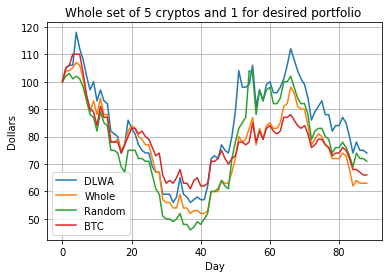

In [14]:
desired_portfolio = 1
initial_investment = 100
portfolio_choices = {}
for t in z.keys():
    ordered = sorted(list(z[t].items()),key=lambda x: x[1],reverse=True)
    portfolio_choices[t] = []
    for i in range(desired_portfolio):
        portfolio_choices[t].append(ordered[i][0])
    
dlwa = {}
whole = {}
random_portfolio = {}
dlwa_values = [initial_investment]
whole_values = [initial_investment]
random_values = [initial_investment]
investment_btc = [initial_investment]
for i in range(desired_portfolio):
    dlwa[i] = [initial_investment/desired_portfolio]
    random_portfolio[i] = [initial_investment/desired_portfolio]
for i in range(resources):
    whole[i] = [initial_investment/resources]
random.seed(100)

cryptos = list(attr_values.keys())
for t in range(time_horizon):
    day_value = 0
    day_whole_value = 0
    day_random = 0
    btc = investment_btc[t]/prices['BTC'][t][0]
    investment_btc.append(int(round(btc*prices['BTC'][t][1])))
    for i in range(resources):
        buying_from_whole = whole[i][-1]/prices[cryptos[i]][t][0]
        whole[i].append(int(round(buying_from_whole*prices[cryptos[i]][t][1])))
        day_whole_value += whole[i][-1]
    whole_values.append(day_whole_value)
    for i in range(desired_portfolio):
        any_crypto = random.choice(cryptos)
        buying_random = random_portfolio[i][-1]/prices[any_crypto][t][0]
        random_portfolio[i].append(int(round(buying_random*prices[any_crypto][t][1])))
        day_random += random_portfolio[i][-1]
        buying_dlwa = dlwa[i][-1]/prices[portfolio_choices[t][i]][t][0]
        dlwa[i].append(int(round(buying_dlwa*prices[portfolio_choices[t][i]][t][1])))
        day_value += dlwa[i][-1]
    dlwa_values.append(day_value)
    random_values.append(day_random)
time = np.arange(time_horizon+1)
plt.plot(time,dlwa_values)
plt.plot(time,whole_values)
plt.plot(time,random_values)
plt.plot(time,investment_btc)

axes = plt.gca()
plt.ylabel("Dollars")
plt.xlabel("Day")
plt.grid(True)
plt.legend(["DLWA", "Whole","Random","BTC"])
plt.title("Whole set of " + str(resources) + " cryptos and " + str(desired_portfolio) + " for desired portfolio ")
plt.show()
#uncomment next line for exporting figure
#plt.savefig(str(resources) + " cryptos-and-" + str(desired_portfolio) + "in-portfolio.eps")